41506_right.png


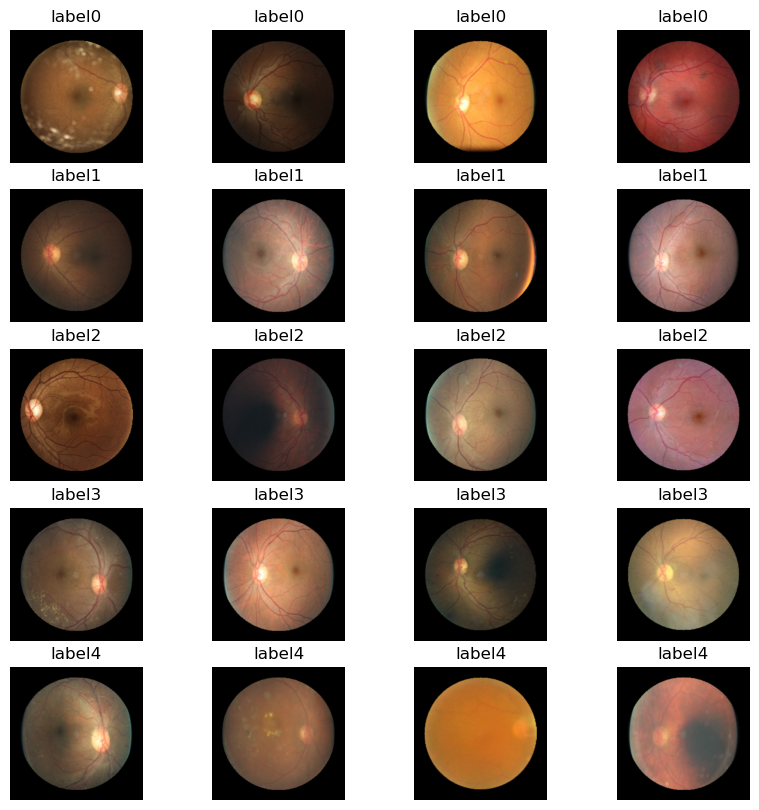

In [1]:
import cv2
import numpy as np
import os
import random
import csv
import shutil
from scipy.signal import wiener
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv


def crop_image(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        cropped_img = img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
    return img


def circle_crop(img):
    cropped_img = crop_image(img)

    height, width, depth = cropped_img.shape
    largest_side = np.max((height, width))
    resized_img = cv2.resize(cropped_img, (largest_side, largest_side))

    height, width, depth = resized_img.shape

    x = width // 2
    y = height // 2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(resized_img, resized_img, mask=circle_img)
    img = crop_image(img)

    return img


def crop_and_resize(image_path, target_size=(400, 400)):
    image = cv2.imread(image_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    average_pixel_value = np.mean(gray_image)
    if average_pixel_value < 5:
        image = cv2.resize(image, target_size)
        cv2.imwrite(image_path, image)
        return

    image = circle_crop(image)

    # Agregar un margen de 4 píxeles a la imagen
    border_color = [0, 0, 0]  # Color negro para el borde
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=border_color)

    image = cv2.resize(image, target_size)
    cv2.imwrite(image_path, image)
    
    
    

def get_full_image_path(main_dir, img_name):
    for dirpath, dirnames, filenames in os.walk(main_dir):
        if img_name in filenames:
            return os.path.join(dirpath, img_name)
    return None



def enhance_contrast(image): 
    image = np.uint8(image)
    # Split the image into RGB channels
    red_channel, green_channel, blue_channel = cv2.split(image)
    # Apply CLAHE to the green channel only
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    green_channel = wiener(green_channel, 2, 0.01) # weiner filter
    green_enhanced = clahe.apply(np.uint8(green_channel))
    red_enhanced = clahe.apply(np.uint8(red_channel))
    blue_enhanced = clahe.apply(np.uint8(blue_channel))
    # Merge the enhanced green channel with the original red and blue channels
    enhanced_image = cv2.merge([red_channel, green_enhanced, blue_channel])
    # enhanced_image = cv2.blur(image, (4, 4)) # median filter
    return enhanced_image


def preprocess_image(img):
    img = enhance_contrast(img)
    return img


out_dir = os.getcwd() # running on the current folder
img_dir = img_dir = r'C:\Users\valen\OneDrive\Escritorio\Universidad\Procesamiento_digital_de_Imagenes\Proyecto Final\colored_images\colored_images'
label_csv = r'C:\Users\valen\OneDrive\Escritorio\Universidad\Procesamiento_digital_de_Imagenes\Proyecto Final\trainLabels.csv'
train_dir = os.path.join(out_dir, 'train')
valid_dir = os.path.join(out_dir, 'tmp_valid')
test_dir = os.path.join(out_dir, 'tmp_test')

if os.path.isdir(train_dir):
    shutil.rmtree(train_dir)
if os.path.isdir(valid_dir):
    shutil.rmtree(valid_dir)
if os.path.isdir(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(valid_dir)
os.makedirs(test_dir)
labels = ['label0', 'label1', 'label2', 'label3', 'label4']

for label in labels:
    os.makedirs(os.path.join(train_dir, label))
    os.makedirs(os.path.join(valid_dir, label))
    os.makedirs(os.path.join(test_dir, label))

# open csv file and read to dict img - label
img_labels = {}
with open(label_csv, 'r') as f:
    reader = csv.reader(f)
    next(reader) # skip header row
    for row in reader:
        img_name = row[0] + '.png'
        label = int(row[1])
        img_labels[img_name] = label

# randomly select one fifth of the images and write their rows to a new CSV file
img_number = int(len(list(img_labels.keys()))/50) # change to /3, /2 or /1 for bigger dataset 

selected_imgs = random.sample(list(img_labels.keys()), img_number)
random.shuffle(selected_imgs)
print(selected_imgs[0])

# split the selected imgs to train, test and validation
train_ratio = 0.7 
valid_ratio = 0.2 
test_ratio = 0.1

train_split = int(len(selected_imgs) * train_ratio)
valid_split = int(len(selected_imgs) * valid_ratio)

train_imgs = selected_imgs[:train_split]
valid_imgs = selected_imgs[train_split:train_split+valid_split]
test_imgs = selected_imgs[train_split+valid_split:]

for img_name in train_imgs:
    label = img_labels[img_name]
    src_path = get_full_image_path(img_dir, img_name)
    if not src_path:
        print(f"Image {img_name} not found in any subfolder!")
        continue
    dst_path = os.path.join(train_dir, labels[label], img_name)
    shutil.copy(src_path, dst_path)
    crop_and_resize(dst_path)

for img_name in valid_imgs:
    label = img_labels[img_name]
    src_path = get_full_image_path(img_dir, img_name)
    if not src_path:
        print(f"Image {img_name} not found in any subfolder!")
        continue
    dst_path = os.path.join(valid_dir, labels[label], img_name)
    shutil.copy(src_path, dst_path)
    crop_and_resize(dst_path)

for img_name in test_imgs:
    label = img_labels[img_name]
    src_path = get_full_image_path(img_dir, img_name)
    if not src_path:
        print(f"Image {img_name} not found in any subfolder!")
        continue
    dst_path = os.path.join(test_dir, labels[label], img_name)
    shutil.copy(src_path, dst_path)
    crop_and_resize(dst_path)
    
dir = train_dir
images = []
num = 4
for label in labels:
    img_dir = os.path.join(dir, label)
    image_paths = os.listdir(img_dir)
    image_paths = list(map(lambda img: os.path.join(img_dir, img), image_paths))
    images.extend(random.sample(image_paths, num))
plt.figure(figsize=(10, 10))
for i in range(5 * num):
    image = plt.imread(images[i])
   # image = preprocess_image(image)
    ax = plt.subplot(5, num, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(labels[int(i/num)])
    plt.axis("off")

In [2]:

labels = ['label0', 'label1', 'label2', 'label3', 'label4']
# Specify the paths to the train folder and the augmented output folder
train_dir = 'train'
aug_dir = 'aug'

if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)

os.makedirs(aug_dir)

for label in labels:
    os.makedirs(os.path.join(aug_dir, label))
    
# create data frame
train_paths = []
label_image = []
for label in labels:
    for image_path in [os.path.join(train_dir, label, image) for image in os.listdir(os.path.join(train_dir, label))]:
        train_paths.append(image_path)
        label_image.append(label)
        
Fseries=pd.Series(train_paths, name='filepaths')
Lseries=pd.Series(label_image, name='labels')
train_df = pd.concat([Fseries, Lseries], axis = 1)

In [3]:
df = train_df
df_right_eye = df[df['filepaths'].str.contains('_right.png')]
df_left_eye = df[df['filepaths'].str.contains('_left.png')]
df_left_eye 

,filepaths,labels
0,train\label0\10032_left.png,label0
2,train\label0\10276_left.png,label0
10,train\label0\11313_left.png,label0
12,train\label0\11607_left.png,label0
14,train\label0\11775_left.png,label0
...,...,...
483,train\label4\16114_left.png,label4
484,train\label4\26772_left.png,label4
485,train\label4\2804_left.png,label4
488,train\label4\4496_left.png,label4


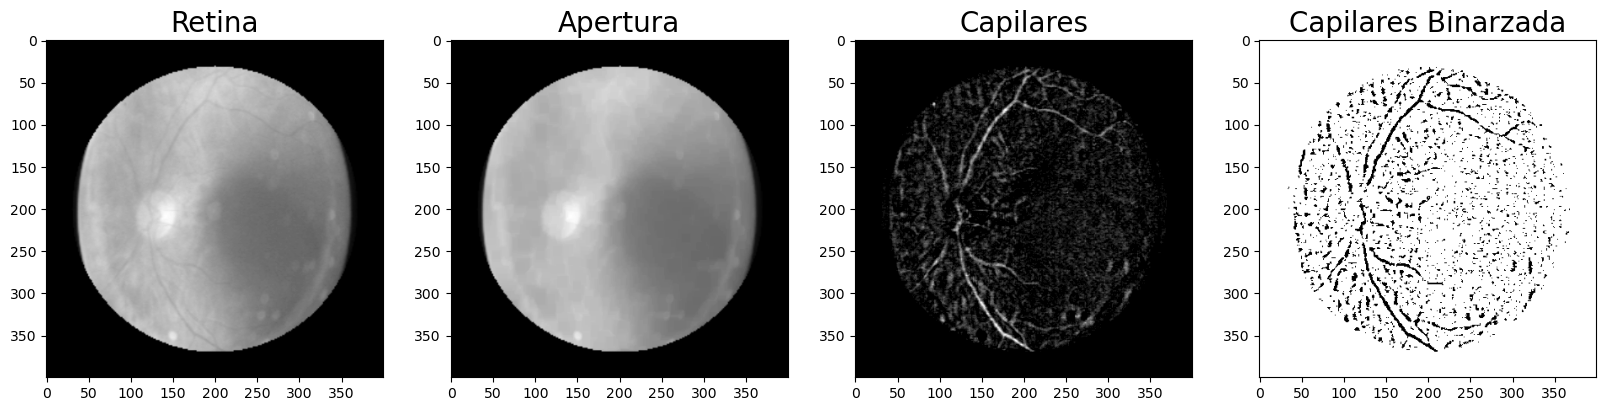

In [4]:

array= df_right_eye[df_right_eye['labels']=='label4'].values

img_path = array[2][0]
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

iteracion = 4

kernel = np.ones((3,3),np.uint8)
erosion = cv.dilate(img,kernel,iterations = iteracion)

plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
plt.title("Retina",fontsize=20)
plt.imshow(img, cmap='gray')


apertura = cv.erode(erosion, kernel, iterations= iteracion)

plt.subplot(1,4,2)
plt.title("Apertura",fontsize=20)
plt.imshow(apertura, cmap='gray')

capilares = apertura - img 

plt.subplot(1,4,3)
plt.title("Capilares",fontsize=20)
plt.imshow(capilares, cmap='gray')

capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                     cv2.THRESH_BINARY, 11, 2)

plt.subplot(1,4,4)
plt.title("Capilares Binarzada",fontsize=20)
plt.imshow(capilares_binarizada, cmap='gray')

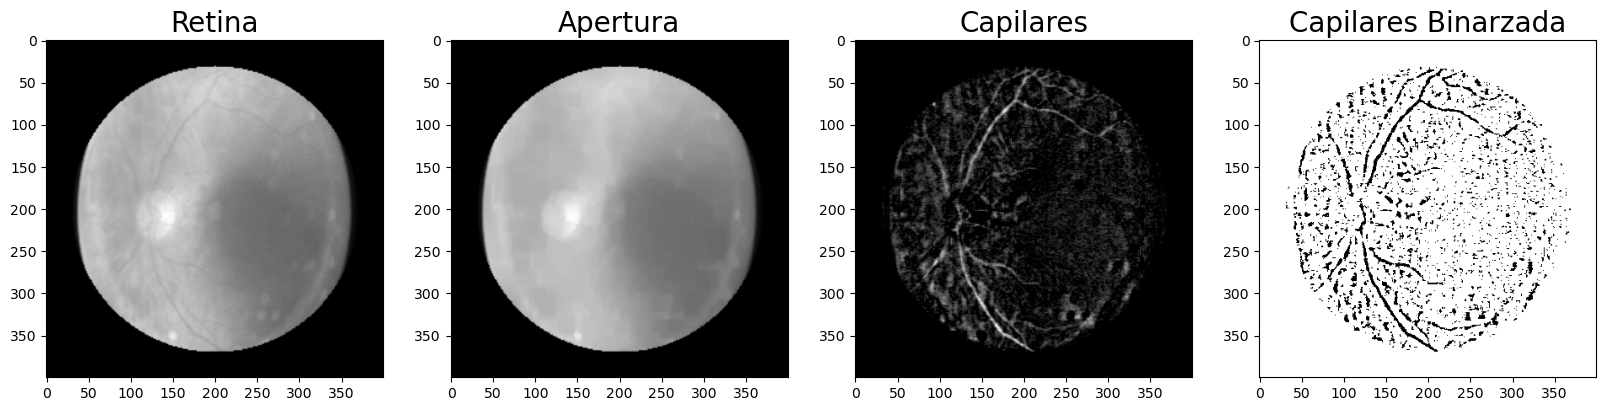

In [5]:
array= df_right_eye[df_right_eye['labels']=='label4'].values

img_path = array[2][0]
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

iteracion = 6

kernel = np.ones((3,3),np.uint8)
erosion = cv.dilate(img,kernel,iterations = iteracion)

plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
plt.title("Retina",fontsize=20)
plt.imshow(img, cmap='gray')


apertura = cv.erode(erosion, kernel, iterations= iteracion)

plt.subplot(1,4,2)
plt.title("Apertura",fontsize=20)
plt.imshow(apertura, cmap='gray')

capilares = apertura - img 

plt.subplot(1,4,3)
plt.title("Capilares",fontsize=20)
plt.imshow(capilares, cmap='gray')

capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                     cv2.THRESH_BINARY, 11, 2)

plt.subplot(1,4,4)
plt.title("Capilares Binarzada",fontsize=20)
plt.imshow(capilares_binarizada, cmap='gray')

In [6]:
def rotar(imagen):    
    # Determinar el centro de la imagen
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)

    # Definir el ángulo de rotación (en grados)
    angle = 180  # Por ejemplo, para rotar 45 grados

    # Obtener la matriz de rotación
    M = cv2.getRotationMatrix2D(center, angle, 1.0)  # El último argumento es el factor de escala

    # Realizar la rotación
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

train\label0\11313_left.png
train\label1\16197_left.png
train\label2\1178_left.png
train\label3\36130_left.png


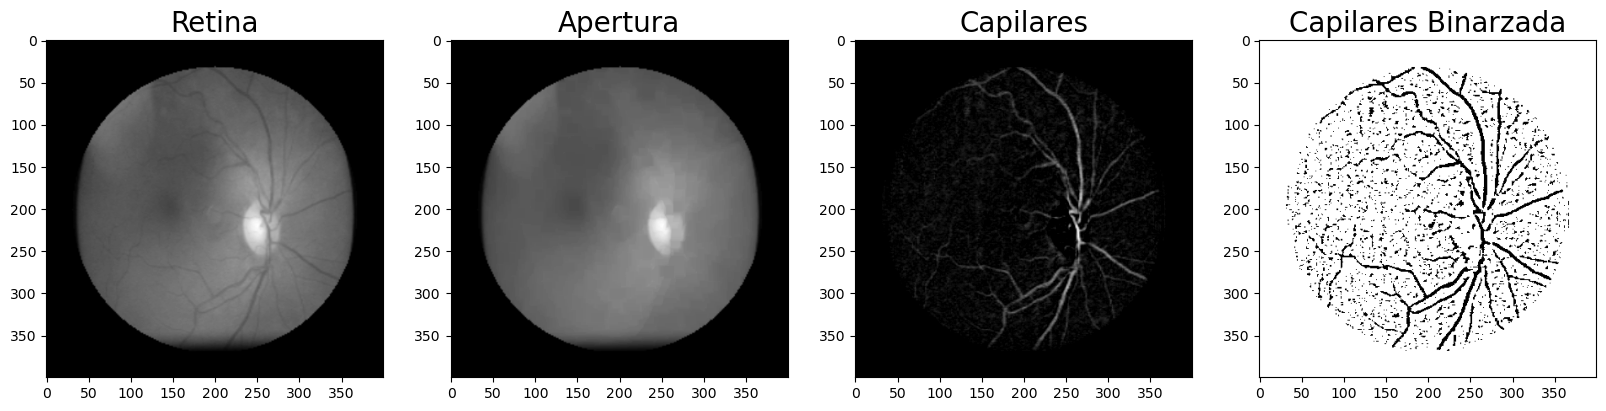

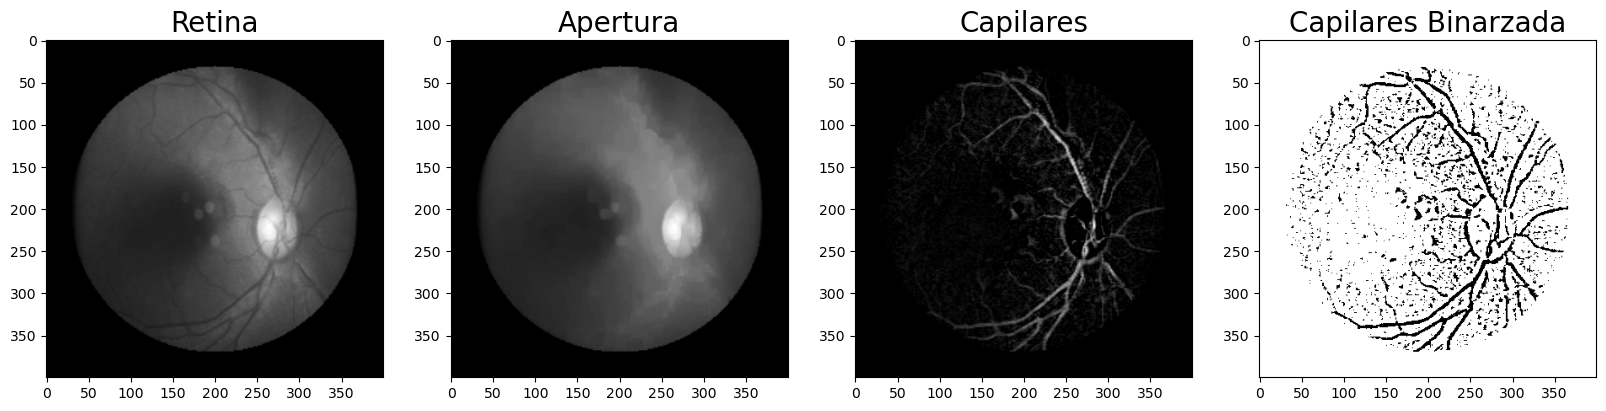

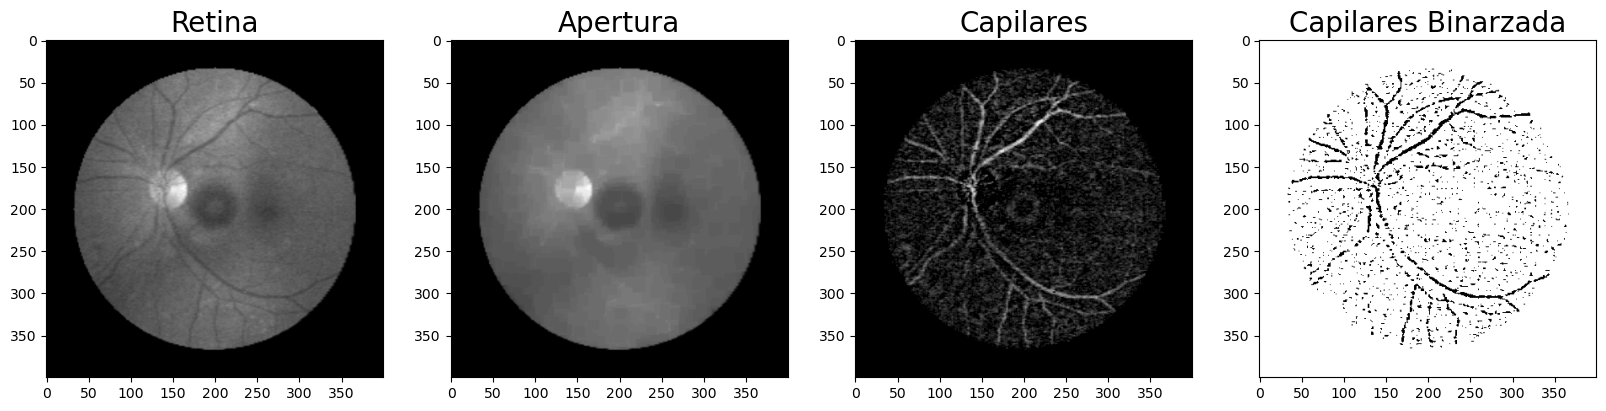

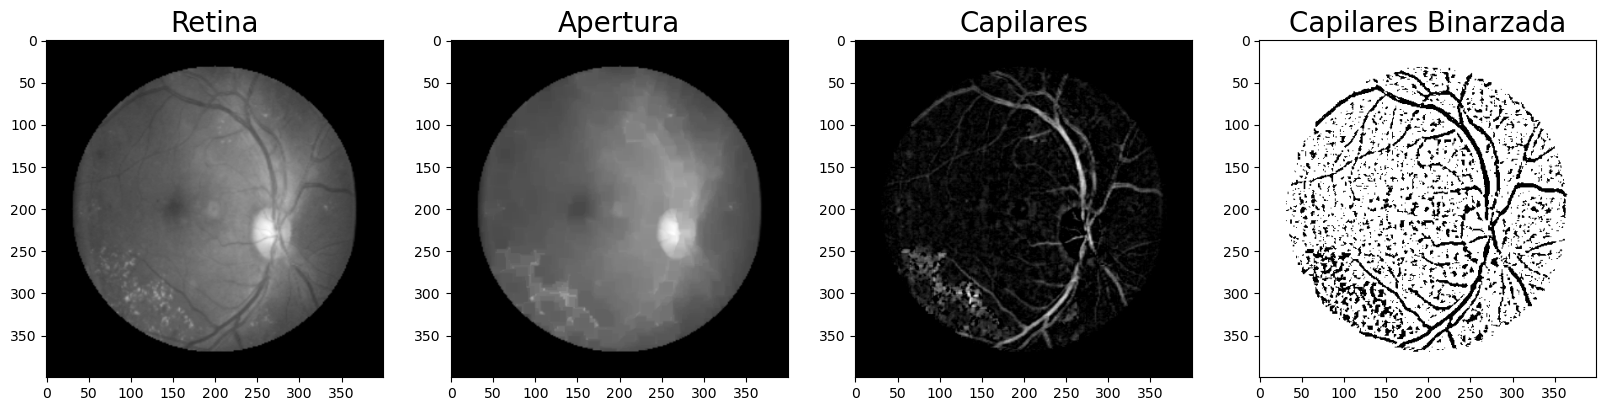

In [14]:
for i in range(4):    
    array= df_left_eye[df_left_eye['labels']==f'label{i}'].values
    
    img_path = array[2][0]
    
    
    
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    
    iteracion = 5

    kernel = np.ones((3,3),np.uint8)
    erosion = cv.dilate(img,kernel,iterations = iteracion)

    plt.figure(figsize=(20,20))

    plt.subplot(1,4,1)
    plt.title("Retina",fontsize=20)
    plt.imshow(img, cmap='gray')


    apertura = cv.erode(erosion, kernel, iterations= iteracion)

    plt.subplot(1,4,2)
    plt.title("Apertura",fontsize=20)
    plt.imshow(apertura, cmap='gray')

    capilares = apertura - img 

    plt.subplot(1,4,3)
    plt.title("Capilares",fontsize=20)
    plt.imshow(capilares, cmap='gray')

    capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

    plt.subplot(1,4,4)
    plt.title("Capilares Binarzada",fontsize=20)
    plt.imshow(capilares_binarizada, cmap='gray')
    print(img_path)
    

In [8]:
for i in range(4):    
    array= df_left_eye[df_left_eye['labels']==f'label{i}'].values
    img_path = array[0][0]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    iteracion = 9

    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.dilate(img,kernel,iterations = iteracion)
    apertura = cv2.erode(erosion, kernel, iterations= iteracion)
    capilares = apertura - img 
    capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

    image = capilares_binarizada
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    orientation = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180  # Convertir a grados y mantenerlo en [0, 180)
    hist, bins = np.histogram(orientation, bins=36, range=(0, 180))
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Agregar el histograma a la figura
    fig.add_trace(go.Bar(x=bin_centers, y=hist, name=f'Orientación Label {i}', marker_color=colors[i % len(colors)]))

# Configurar y mostrar la figura
fig.update_layout(
    title='Histograma de Orientación',
    xaxis_title='Orientación (grados)',
    yaxis_title='Frecuencia',
    yaxis_type="log",
    xaxis=dict(range=[0, 180])
)

fig.show()


In [18]:

import cv2
import numpy as np
import plotly.graph_objects as go

# Lista de colores
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']

# Inicializar la figura
fig = go.Figure()

for i in range(4):    
    array= df_left_eye[df_left_eye['labels']==f'label{i}'].values
    for j in range(4):
        img_path = array[i][0]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if (j == 0):
           img = rotar(img) 
        iteracion = 2


        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.dilate(img,kernel,iterations = iteracion)
        apertura = cv2.erode(erosion, kernel, iterations= iteracion)
        capilares = apertura - img 
        capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                            cv2.THRESH_BINARY, 11, 2)

        # Cargar la imagen y convertirla a escala de grises
        image = capilares_binarizada

        # Calcular el gradiente en las direcciones x e y
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

        # Calcular la orientación del gradiente
        orientation = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180  # Convertir a grados y mantenerlo en [0, 180)

        # Crear el histograma de orientación
        hist, bins = np.histogram(orientation, bins=36, range=(0, 180))
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Agregar el histograma a la figura usando scatter
        fig.add_trace(go.Scatter(x=bin_centers, y=hist, mode='lines+markers', name=f'Orientación Label {i}', marker_color=colors[i % len(colors)]))

    # Configurar y mostrar la figura
    fig.update_layout(
        title='Histograma de Orientación',
        xaxis_title='Orientación (grados)',
        yaxis_title='Frecuencia',
        h = 400,
        w= 200,
        yaxis_type="log",
        xaxis=dict(range=[0, 180])
    )

fig.show()


ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'h'

Did you mean "geo"?

    Valid properties:
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to an
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendiciclecolors
            If `true`, the icicle slice colors (whether given by
            `iciclecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to an "opacity" to see
            multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            `hiddenlabels`.
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled.
        iciclecolorway
            Sets the default icicle slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendiciclecolors`.
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        smith
            :class:`plotly.graph_objects.layout.Smith` instance or
            dict with compatible properties
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to an "opacity" to see multiple
            bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "geo"?

Bad property path:
h
^

In [19]:
import cv2
import numpy as np
import plotly.graph_objects as go

colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']

# Inicializar la figura
fig = go.Figure()

for i in range(4):    
    array = df_left_eye[df_left_eye['labels'] == f'label{i}'].values
    
    for j in range(6):
        img_path = array[j][0]  # Cambia 'i' por 'j' para iterar sobre diferentes imágenes
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if (j == 0):
           img = rotar(img) 
        iteracion = 8


        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.dilate(img, kernel, iterations=iteracion)
        apertura = cv2.erode(erosion, kernel, iterations=iteracion)
        capilares = apertura - img 
        capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                                     cv2.THRESH_BINARY, 11, 2)

        # Cargar la imagen y convertirla a escala de grises
        image = capilares_binarizada

        # Calcular el gradiente en las direcciones x e y
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

        # Calcular la orientación del gradiente
        orientation = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180  # Convertir a grados y mantenerlo en [0, 180)

        # Crear el histograma de orientación
        hist, bins = np.histogram(orientation, bins=36, range=(0, 180))
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Agregar el histograma a la figura usando scatter
        fig.add_trace(go.Scatter(x=bin_centers, y=hist, mode='lines+markers', name=f'Orientación Label {i} - Img {j}', marker_color=colors[i % len(colors)]))

# Configurar y mostrar la figura
fig.update_layout(
    title='Histograma de Orientación',
    xaxis_title='Orientación (grados)',
    yaxis_title='Frecuencia',

        xaxis=dict(range=[20, 180]),
        yaxis=dict(range=[20, 3500])
)

fig.show()


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
import cv2
import numpy as np
import plotly.graph_objects as go

colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']

# Inicializar la figura
fig = go.Figure()

# Lista para almacenar las medias de frecuencia
mean_frequencies = []

for i in range(4):    
    array = df_left_eye[df_left_eye['labels'] == f'label{i}'].values
    
    for j in range(5):
        img_path = array[j][0]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if (j == 0):
           img = rotar(img) 
        iteracion = 6

        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.dilate(img, kernel, iterations=iteracion)
        apertura = cv2.erode(erosion, kernel, iterations=iteracion)
        capilares = apertura - img 
        capilares_binarizada = cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                                     cv2.THRESH_BINARY, 11, 2)

        # Cargar la imagen y convertirla a escala de grises
        image = capilares_binarizada

        # Calcular el gradiente en las direcciones x e y
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

        # Calcular la orientación del gradiente
        orientation = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180

        # Crear el histograma de orientación
        hist, bins = np.histogram(orientation, bins=36, range=(0, 180))
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Agregar la media de frecuencia a la lista
        mean_frequencies.append(np.mean(hist))
        print(hist)
        # Agregar el histograma a la figura usando scatter
        fig.add_trace(go.Scatter(x=bin_centers, y=hist, mode='lines+markers', name=f'Orientación Label {i} - Img {j}', marker_color=colors[i % len(colors)]))

# Configurar y mostrar la figura
fig.update_layout(
    title='Histograma de Orientación',
    xaxis_title='Orientación (grados)',
    yaxis_title='Frecuencia',
    yaxis_type="log",
    xaxis=dict(range=[0, 180])
)

fig.show()

print(hist)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'


In [ ]:
array =[34789 ,  507,   644   ,823,   565 , 1080   ,794  ,593,   226  ,2608  , 607 ,  837,
  1118 ,  616 ,  790   ,705  , 554   ,440 , 1859  , 466 ,  600  , 645 ,  512  , 990,
   718  , 536  , 213 , 2312 , 600   ,772 , 1094 , 549 ,  745 ,  675,   547,   371]
np.mean(array)

1736.111111111111

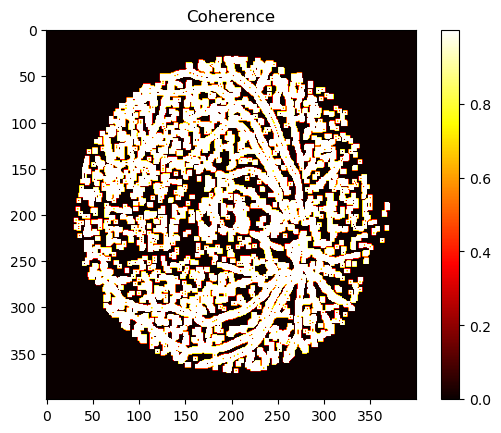

In [ ]:
import cv2
import numpy as np

def compute_coherence(image):
    # Calcular las derivadas en las direcciones x e y
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calcular productos de derivadas
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy
    
    # Calcular la matriz de gradiente para cada píxel
    lambda1 = Ix2 + Iy2 + np.sqrt((Ix2 - Iy2) ** 2 + 4 * Ixy ** 2)
    lambda2 = Ix2 + Iy2 - np.sqrt((Ix2 - Iy2) ** 2 + 4 * Ixy ** 2)
    
    # Calcular la coherencia
    coherence = np.sqrt((lambda1 - lambda2) ** 2) / (lambda1 + lambda2 + 1e-5)  # Se añade un pequeño valor para evitar la división por cero
    
    return coherence

# Cargar la imagen y convertirla a escala de grises

image = capilares_binarizada/255

coherence = compute_coherence(image)

# Visualizar la coherencia
plt.imshow(coherence, cmap='hot')
plt.colorbar()
plt.title('Coherence')
plt.show()


In [11]:
import numpy as np
import cv2
import plotly.graph_objects as go

def fractal_dimension(Z, threshold=0.9):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


# Cargar la imagen y convertirla a escala de grises
labels = ['label0', 'label1', 'label2', 'label3']
fractal_dimensions = []

for i in range(4):    
    array = df_left_eye[df_left_eye['labels'] == f'label{i}'].values
    label_values = []
    
    for j in range(9):
        img_path = array[j][0]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Aplicar binarización
        _, binarized = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

        # Calcular la dimensión fractal
        fd = fractal_dimension(binarized)
        label_values.append(fd)

    
    fractal_dimensions.append(label_values)

# Graficar las dimensiones fractales
fig = go.Figure()

for i, label in enumerate(labels):
    fig.add_trace(go.Bar(x=[f'{label} - Img {j}' for j in range(8)], y=fractal_dimensions[i], name=label))

fig.update_layout(
    title='Dimensión Fractal por Etiqueta e Imagen',
    xaxis_title='Etiqueta - Imagen',
    yaxis_title='Dimensión Fractal',
    yaxis_type="log",
    barmode='group'
)

fig.show()


C:\Users\valen\AppData\Local\Temp\ipykernel_88576\2450216852.py:39: RuntimeWarning:

divide by zero encountered in log



IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
import numpy as np
import cv2
import plotly.graph_objects as go

def fractal_dimension(Z, threshold=0.9):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


# Cargar la imagen y convertirla a escala de grises
labels = ['label0', 'label1', 'label2', 'label3']
fractal_dimensions = []

for i in range(4):    
    array = df_left_eye[df_left_eye['labels'] == f'label{i}'].values
    label_values = []
    
    for j in range(9):
        img_path = array[j][0]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if (j == 0):
            img = rotar(img)  # Asumiendo que ya tienes definida la función rotar
        
        iteracion = 20
        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.dilate(img, kernel, iterations=iteracion)
        apertura = cv2.erode(erosion, kernel, iterations=iteracion)
        capilares = apertura - img 

        # Aplicar binarización
        binarized =  cv2.adaptiveThreshold(255 - capilares, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                                     cv2.THRESH_BINARY, 11, 2)

        # Calcular la dimensión fractal
        fd = fractal_dimension(binarized)
        label_values.append(fd)
    
    fractal_dimensions.append(label_values)

# Graficar las dimensiones fractales
fig = go.Figure()

for i, label in enumerate(labels):
    fig.add_trace(go.Bar(x=[f'{label} - Img {j}' for j in range(9)], y=fractal_dimensions[i], name=label))

fig.update_layout(
    title='Dimensión Fractal por Etiqueta e Imagen',
    xaxis_title='Etiqueta - Imagen',
    yaxis_title='Dimensión Fractal',
    yaxis_type="log",
    barmode='group'
)

fig.show()


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'
